In [ ]:
import pandas as pd
import numpy as np
import os
import datetime
from scipy import stats
import missingno as msno

from tqdm import tqdm

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib as mpl
import seaborn as sns

import shapefile as shp

import geopandas as gpd

from mpl_toolkits.axes_grid1 import make_axes_locatable

from bokeh.plotting import figure
from bokeh.io import show, output_notebook, output_file
from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource, Panel
from bokeh.palettes import d3
from bokeh.models.widgets import CheckboxGroup, Slider, RangeSlider, Tabs
from bokeh.layouts import column, row, WidgetBox
from bokeh.application.handlers import FunctionHandler
from bokeh.application import Application

import pickle
from joblib import dump, load

today = datetime.date.today().strftime("%y%m%d")

output_notebook()

In [ ]:
filepath = '../data/standvirtual_dataset_merge_200628.csv'
df = pd.read_csv(filepath)

df.head()

In [ ]:
brand = df['brand'].values
model =  df['model'].values

cars = df['brand']+' '+df['model']
cars = cars.values

price = pd.to_numeric(df['price'], errors='coerce')
year = pd.to_numeric(df['first_registration_year'], errors='coerce')

dfX = pd.DataFrame({'brand':brand, 'model':model, 'cars':cars, 'year':year, 'price':price})
dfX = dfX.dropna().reset_index(drop=True)

In [180]:
year_now = int(datetime.date.today().strftime("%Y"))
cars_u = dfX['cars'].unique()

YPA = np.zeros((len(cars_u), 10))*np.nan
for i in range(len(cars_u)):
    car = cars_u[i]
    car_ix = dfX['cars'] == car
    dfX2 = dfX.loc[car_ix].reset_index(drop=True)
    years = np.sort(dfX2['year'].unique())
    years_diff = year_now-years
    years_ix = np.where((years_diff <= 10) & (years_diff != 0))[0]
    for ixx in years_ix:
        year = years[ixx]
        df2 = dfX2.loc[dfX2['year'] == year, 'price']
        if len(df2) > 5:
            YPA[i,int(years_diff[ixx]-1)] = df2.mean()

In [257]:
yd = np.array([10, 5, 2])
min_val = [5, 3, 2]

S = np.zeros((len(cars),len(yd)))*np.nan
for i in range(len(cars_u)):
    for j in range(len(yd)):
        val = yd[j]
        y = YPA[i,-yd[j]:]
        mask = ~np.isnan(y)
        n_val = np.sum(mask)
        if n_val >= min_val[j]:
            slope, intercept, r_value, p_value, std_err = stats.linregress(np.arange(yd[j])[mask], y[mask])
            S[i,j] = slope*yd[j]

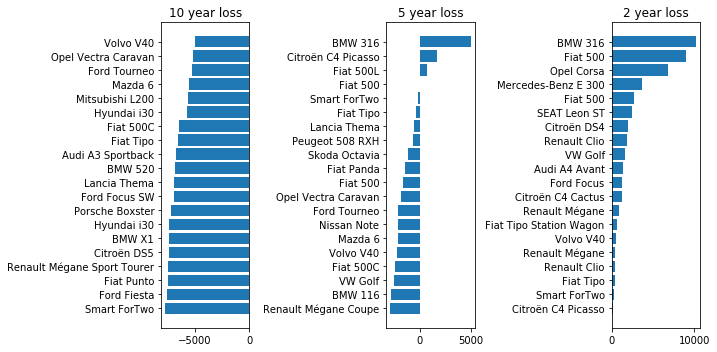

In [261]:
ntop = 20

fig, ax = plt.subplots(1,3, figsize=[10,5])
for i in range(len(yd)):
    ix = np.where(~np.isnan(S[:,i]))[0]
    ix2 = np.argsort(S[ix,i])[::-1]
    p_diff = S[ix[ix2], i][:ntop][::-1]
    labs = cars[ix[ix2]][:ntop][::-1]    
    ax[i].barh(np.arange(len(p_diff)), p_diff)
    ax[i].set_yticks(np.arange(len(p_diff)))
    ax[i].set_yticklabels(labs);    
    ax[i].set_title('%d year loss'%(yd[i]))
plt.tight_layout()
